In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
df = pd.read_csv('Reddit_Sentiment_BNB.csv')
df.head()

,date,text,Reddit_Flair,Reddit_TB_Polarity,Reddit_TB_Subjectivity,Reddit_Vader_Pos,Reddit_Vader_Neg,Reddit_Vader_Neu,Reddit_Vader_Compound
0,2022-01-01 00:04:39,Transferring ADA back to Binance from Binance ...,-0.999990,-0.010119,0.290377,0.021,0.094,0.885,-0.7707
1,2022-01-01 00:07:44,IPad Binance App,0.860817,0.000000,0.000000,0.000,0.000,1.000,0.0000
2,2022-01-01 00:08:44,Have you ever sent coins from Metamask into th...,-0.998341,0.250000,0.333333,0.000,0.000,1.000,0.0000
3,2022-01-01 00:28:52,"Binance has closed its China market, will this...",-0.997731,-0.100000,0.100000,0.000,0.000,1.000,0.0000
4,2022-01-01 01:01:44,Ontario securities regulator slams Binance aft...,-0.995651,0.000000,0.000000,0.145,0.000,0.855,0.2960


In [4]:
df1 = pd.read_excel('BNB_CRYPTO.xlsx')
df1.head()

,unix,date,symbol,open,high,low,close,Volume BNB,Volume USDT,tradecount
0,1648681200000,2022-03-30 23:00:00,BNB/USDT,443.1,444.1,441.6,442.1,28447.377,1.260756e+07,11376
1,1648677600000,2022-03-30 22:00:00,BNB/USDT,442.7,443.6,441.0,443.1,20493.516,9.067476e+06,13292
2,1648674000000,2022-03-30 21:00:00,BNB/USDT,446.2,446.3,441.5,442.6,29578.972,1.311486e+07,16727
3,1648670400000,2022-03-30 20:00:00,BNB/USDT,444.8,446.6,444.3,446.2,23738.269,1.057612e+07,14162
4,1648666800000,2022-03-30 19:00:00,BNB/USDT,445.2,445.8,441.8,444.8,35564.184,1.578383e+07,20509


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%y-%m-%d-%H')
df1['date'] = df1['date'].dt.strftime('%y-%m-%d-%H')

In [6]:
#merge = [df,df1]
#merge = pd.concat(merge)
merge = pd.merge(df,df1,on='date')
merge.set_index('date',inplace=True)
merge.sort_values(by='date',inplace=True)

In [8]:
merge.columns

Index(['text', 'Reddit_Flair', 'Reddit_TB_Polarity', 'Reddit_TB_Subjectivity',
       'Reddit_Vader_Pos', 'Reddit_Vader_Neg', 'Reddit_Vader_Neu',
       'Reddit_Vader_Compound', 'unix', 'symbol', 'open', 'high', 'low',
       'close', 'Volume BNB', 'Volume USDT', 'tradecount'],
      dtype='object')

In [9]:
merge.drop('text',axis=1,inplace=True)
#merge.drop('Unnamed: 0',axis=1,inplace=True)
merge.drop('unix',axis=1,inplace=True)
merge.drop('symbol',axis=1,inplace=True)
#merge.drop('text',axis=1,inplace=True)
#merge.drop('Date',axis=1,inplace=True)
#df.drop('Text',axis=1,inplace=True)

In [11]:
dataset = merge.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
num_of_features = len(merge.columns)
print('Number of features', num_of_features)

Number of features 14


In [12]:
expr_name = 'expr_3'
look_back = 24*7 
lstm_layers = 32
epochs=10
batch_size=128

In [14]:
train_size_percent = 0.75
pred_col = merge.columns.get_loc('close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  2373
Testing dataset length  791
look_back  168


In [15]:
model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
BTC = model.fit(trainX, trainY,validation_split=0.25, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/10
13/13 [==============================] - 2s 87ms/step - loss: 0.1644 - val_loss: 0.0351
Epoch 2/10
13/13 [==============================] - 1s 59ms/step - loss: 0.0217 - val_loss: 0.0071
Epoch 3/10
13/13 [==============================] - 1s 57ms/step - loss: 0.0086 - val_loss: 0.0020
Epoch 4/10
13/13 [==============================] - 1s 57ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 5/10
13/13 [==============================] - 1s 55ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 6/10
13/13 [==============================] - 1s 59ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/10
13/13 [==============================] - 1s 58ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/10
13/13 [==============================] - 1s 56ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/10
13/13 [==============================] - 1s 61ms/step - loss: 0.0012 - val_loss: 9.5425e-04
Epoch 10/10
13/13 [==============================] - 1s 57ms/step - loss: 0.0012 - val_loss: 9.3231e-04


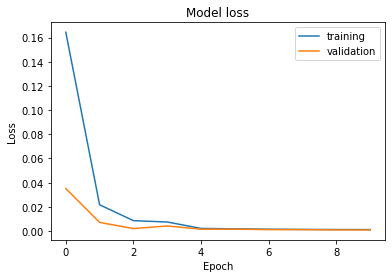

In [16]:
# Plot training
plt.plot(BTC.history['loss'])
plt.plot(BTC.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

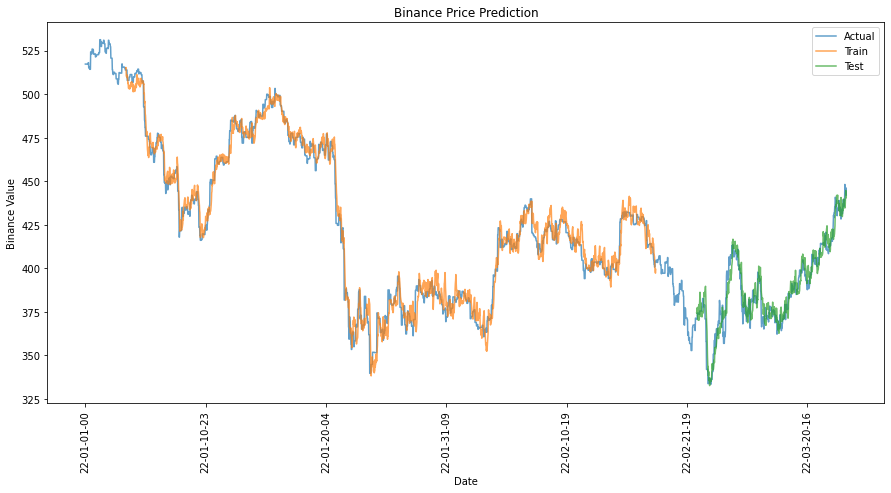

In [19]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(merge.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=True)
time_df2.set_index('date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Binance Value')
plt.title('Binance Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [20]:
print('-' * 100)
print('Experiment name:', expr_name)
print('-' * 100)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(df.columns))
print('-' * 100)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))
print('-' * 100)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))
print('-' * 100)
print('Model summary:')
model.summary()

----------------------------------------------------------------------------------------------------
Experiment name: expr_3
----------------------------------------------------------------------------------------------------
look_back days: 7.0
lstm_layers: 32
epochs: 10
batch_size: 128
dataset features ['date', 'text', 'Reddit_Flair', 'Reddit_TB_Polarity', 'Reddit_TB_Subjectivity', 'Reddit_Vader_Pos', 'Reddit_Vader_Neg', 'Reddit_Vader_Neu', 'Reddit_Vader_Compound']
----------------------------------------------------------------------------------------------------
Train Score: 6.55 RMSE
Test Score: 7.04 RMSE
----------------------------------------------------------------------------------------------------
Train Score: 4.89 MAE
Test Score: 5.50 MAE
----------------------------------------------------------------------------------------------------
Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output 